In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import genextreme as gev
import pooch
import os
import tempfile

# import EVT specific functions
import gev_functions as gf
import extremes_functions as ef
import sdfc_classes as sd

# EVT GEV Modeling Applied to Only Quadrant A of Antarctica

In [2]:
# load cleaned dataset
icebergs = pd.read_csv('largest_annual_iceberg_quadrentA.csv')

In [3]:
icebergs.head(5)

,File_Name,Date,Max_Size_1,Max_Size_2,Area,Year
0,a01.csv,1978-10-22,45,25,3858.6420,1978
1,a04.csv,1979-10-21,30,10,1028.9712,1979
2,a14.csv,1980-12-14,30,20,2057.9424,1980
3,a16.csv,1981-11-15,35,15,1800.6996,1981
4,a17.csv,1983-04-17,25,23,1972.1948,1983


In [4]:
area = icebergs.Area #in square kilometers
year = icebergs.Year

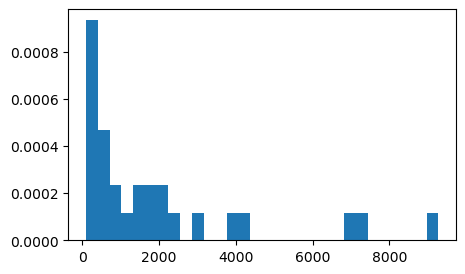

In [5]:
# histogram of iceberg area (sq. km) distributions
plt.figure(figsize=(5,3))
plt.hist(area, bins=30, density=True)
plt.show()

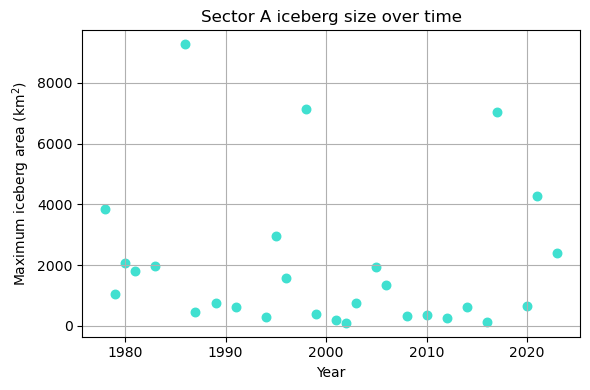

In [6]:
fig = plt.figure(figsize=(6,4))
plt.scatter(year, area, marker='.', facecolor='#40E0D0', s = 150, alpha = 1, label = 'Observations')
plt.grid(True, zorder = 0)
plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (km$^2$)')
plt.title('Sector A iceberg size over time')
plt.tight_layout()
plt.show()

In [7]:
fig.savefig('year_vs_iceberg_size_quadA.jpg', dpi=300, bbox_inches = "tight")

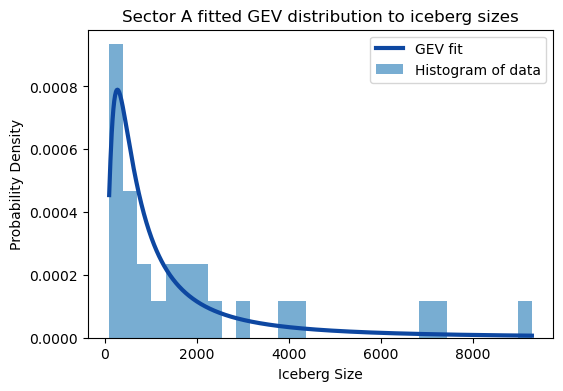

In [8]:
# Fit a GEV distribution to the data
params = gev.fit(area, loc = 1022, scale = 1055)

# Generate some values from the fitted GEV distribution
x = np.linspace(min(area), max(area), 1000)
pdf_fitted = stats.genextreme.pdf(x, *params)
#pdf_fitted = stats.genextreme.pdf(x, -0.76, loc = 1022, scale = 1055)

# Plot the histogram of the data and the fitted GEV distribution
fig = plt.figure(figsize=(6,4))
plt.hist(area, bins=30, density=True, alpha = 0.6)
plt.plot(x, pdf_fitted, '#0D47A1', lw=3)
plt.xlabel('Iceberg Size')
plt.ylabel('Probability Density')
plt.title('Sector A fitted GEV distribution to iceberg sizes')
plt.legend(["GEV fit","Histogram of data"], loc="upper right")
plt.show()

In [9]:
fig.savefig('gev_fit_quadA.jpg', dpi=300, bbox_inches = "tight")

Compute AIC

In [10]:
log_likelihood_gev = np.sum(gev.logpdf(area, *params))
k_gev = len(params)  # Number of parameters in GEV
aic_gev = 2 * k_gev - 2 * log_likelihood_gev
print(aic_gev)

484.7839212105367


In [11]:
shape, loc, scale = params

In [12]:
print("shape: {}, loc: {}, scale: {}".format(shape, loc, scale))

shape: -0.9203407688697544, loc: 593.8126724770347, scale: 649.7798765808261


In [13]:
# bootstrap approach with 100 repetitions (N_boot) to quantify uncertainty range
fit = gf.fit_return_levels(area.values, years=np.arange(1.1, 100), N_boot=100, alpha = 0.05)

Location: 5.9e+02, scale: 6.5e+02, shape: -9.2e-01

Ranges with alpha = 0.050 :
Location: [299.81 , 947.80]
Scale: [323.30 , 1114.20]
Shape: [-1.51 , -0.43]


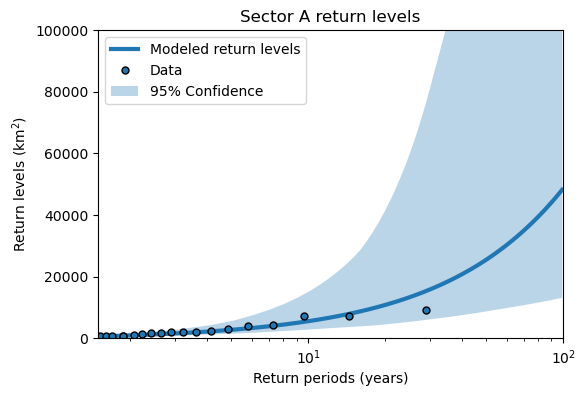

In [14]:
# create figures
fig, ax = plt.subplots(1, 1,figsize=(6,4))
# reduce dimension of axes to have only one index

# create x-data for QQ-plot (top left)
x = np.linspace(0, 1, 100)

# plot return levels 
gf.plot_return_levels(fit, ax=ax)
ax.set_xlim(1.5, 100)
ax.set_ylim(0, 1e5)

# aesthetics
ax.set_title("Sector A return levels")
ax.set_xlabel("Return periods (years)")
ax.set_ylabel("Return levels (km$^2$)")
ax.legend(["Modeled return levels","Data","95% Confidence"], loc="upper left")
plt.show()

In [15]:
fig.savefig('return_period_confidence_quadA.jpg', dpi=300, bbox_inches = "tight")

In [16]:
# X-year of interest
x = 100
print("{}-year return level: {:.2f}".format(x, gf.estimate_return_level_period(x, loc, scale, shape).mean()))

100-year return level: 48583.68


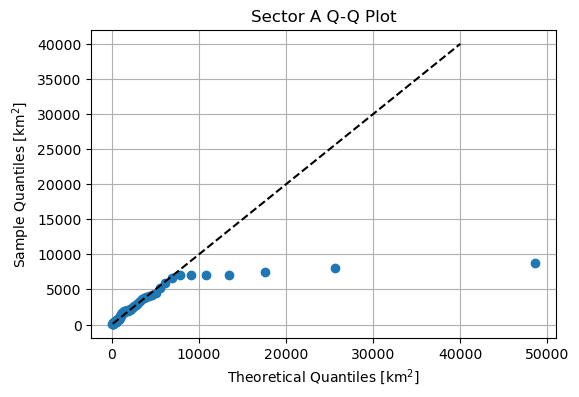

In [17]:
# Generate quantiles from the fitted GEV distribution
fitted_quantiles1 = gev(*params).ppf(np.linspace(0.01, 0.99, 100))

# Generate quantiles from the sample data
data_quantiles1 = np.percentile(area, np.linspace(1, 99, 100))

# Plot the Q-Q plot
fig = plt.figure(figsize=(6,4))
plt.plot(fitted_quantiles1, data_quantiles1, ls="", marker="o")
plt.xlabel('Theoretical Quantiles [km$^2$]')
plt.ylabel('Sample Quantiles [km$^2$]')
plt.title('Sector A Q-Q Plot')
plt.plot([np.min(area), 4e4], [np.min(area), 4e4], color='k', linestyle='--')
plt.grid(True)
plt.show()

In [18]:
fig.savefig('QQ_plot_quadA.jpg', dpi=300, bbox_inches = "tight")

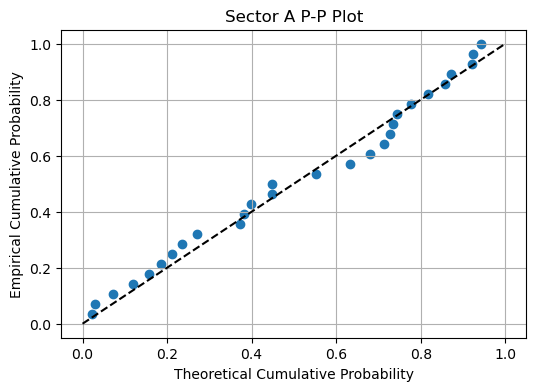

In [19]:

# Create a GEV distribution
gev_dist = gev(c=shape, loc=loc, scale=scale)

# Calculate empirical CDF of the data
sorted_data = np.sort(area)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Calculate theoretical CDF of the GEV distribution
theoretical_cdf = gev_dist.cdf(sorted_data)

# Plot the P-P plot
fig = plt.figure(figsize=(6, 4))
plt.scatter(theoretical_cdf, empirical_cdf, label='P-P Plot')
plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='45-degree Line')
plt.xlabel('Theoretical Cumulative Probability')
plt.ylabel('Empirical Cumulative Probability')
plt.title('Sector A P-P Plot')
#plt.legend()
plt.grid(True)
plt.show()

In [20]:
fig.savefig('PP_plot_quadA.jpg', dpi=300, bbox_inches = "tight")

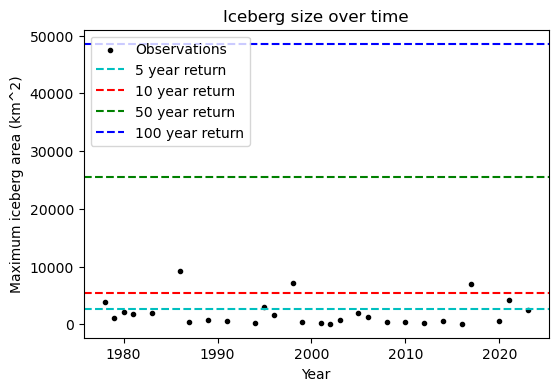

In [21]:
# years of interest
x_years = [10, 50, 100]

fig = plt.figure(figsize=(6,4))
plt.scatter(year, area, marker='.', color='k', label = 'Observations')
plt.axhline(y=gf.estimate_return_level_period(5, loc, scale, shape).mean(), color='c', linestyle='--', label='5 year return')
plt.axhline(y=gf.estimate_return_level_period(10, loc, scale, shape).mean(), color='r', linestyle='--', label='10 year return')  
plt.axhline(y=gf.estimate_return_level_period(50, loc, scale, shape).mean(), color='g', linestyle='--', label='50 year return')
plt.axhline(y=gf.estimate_return_level_period(100, loc, scale, shape).mean(), color='b', linestyle='--', label='100 year return')
plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (km^2)')
plt.title('Iceberg size over time')
plt.legend(loc="upper left")
plt.show()

In [22]:
fig.savefig('return_inervals_quadA.jpg', dpi=300, bbox_inches = "tight")

## Add non-stationarity component

In [23]:
# instantiate a GEV distribution
law_ns = sd.GEV()

In [24]:
# fit the GEV to the data, while specifying that the location parameter ('loc') is meant
# to be a covariate ('c_') of the time axis (data.index)
for i in range(250):
    law_ns.fit(area.values, c_loc=np.arange(year.size))
    #print(law_ns.coef_)
    # if the first coefficient is not zero, we stop fitting
    if law_ns.coef_[0] != 0:
        print(f'Found non-trivial solution after {i} fitting iterations.')
        print(law_ns.coef_)
        break

Found non-trivial solution after 5 fitting iterations.
[892.0348875  -20.65048989 620.20661855   0.92922601]


In [25]:
ef.print_law(law_ns)

+-----------+------------+-------------------+
| GEV (mle) |    Type    |       coef        |
+===========+============+===================+
| loc       | Covariate  | [892.035, -20.65] |
+-----------+------------+-------------------+
| scale     | Stationary | 620.207           |
+-----------+------------+-------------------+
| shape     | Stationary | 0.929             |
+-----------+------------+-------------------+



In [26]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info_.mle_optim_result.fun

In [27]:
compute_aic(law_ns)

484.57823285066314

In [28]:
# log likelihood

def compute_ll(model):
    return -model.info_.mle_optim_result.fun

In [29]:
ll_gev_non_stationary = compute_ll(law_ns)
print(ll_gev_non_stationary)

-238.28911642533157


In [30]:
# llrt
D = 2*(ll_gev_non_stationary - log_likelihood_gev)
print(D)

2.205688359873534


In [31]:
t=np.arange(-5, 50)

In [32]:
mu0 = 892.036
mu1 = -20.651
scale_new = 620.206
shape_new = -0.929

In [33]:
mu = mu0+mu1*t

In [34]:
# 100 year return
zp_nonstationary_values = []

for i, m in enumerate(mu):
    zp_nonstationary = gf.estimate_return_level_period(100, m, scale_new, shape_new).mean()
    zp_nonstationary_values.append(zp_nonstationary)
    
zp_array_100 = np.array(zp_nonstationary_values)
#print(zp_array_100)

In [35]:
# 50 year return
zp_nonstationary_values = []

for i, m in enumerate(mu):
    zp_nonstationary = gf.estimate_return_level_period(50, m, scale_new, shape_new).mean()
    zp_nonstationary_values.append(zp_nonstationary)
    
zp_array_50 = np.array(zp_nonstationary_values)
#print(zp_array_50)

In [36]:
# 10 year return
zp_nonstationary_values = []

for i, m in enumerate(mu):
    zp_nonstationary = gf.estimate_return_level_period(10, m, scale_new, shape_new).mean()
    zp_nonstationary_values.append(zp_nonstationary)
    
zp_array_10 = np.array(zp_nonstationary_values)
#print(zp_array_10)

In [37]:
# 5 year return
zp_nonstationary_values = []

for i, m in enumerate(mu):
    zp_nonstationary = gf.estimate_return_level_period(5, m, scale_new, shape_new).mean()
    zp_nonstationary_values.append(zp_nonstationary)
    
zp_array_5 = np.array(zp_nonstationary_values)
#print(zp_array_5)

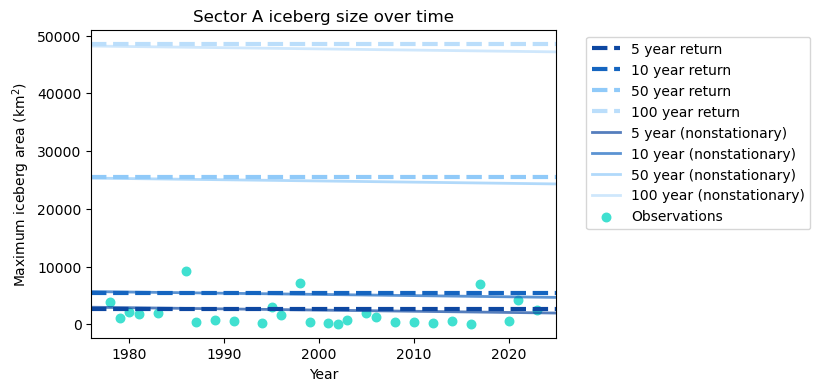

In [38]:
# years of interest
x_years = [5, 10, 50, 100]

fig = plt.figure(figsize=(6,4))
plt.axhline(y=gf.estimate_return_level_period(5, loc, scale, shape).mean(), color='#0D47A1', linestyle='--', linewidth=3, label='5 year return')
plt.axhline(y=gf.estimate_return_level_period(10, loc, scale, shape).mean(), color='#1565C0', linestyle='--', linewidth=3, label='10 year return')
plt.axhline(y=gf.estimate_return_level_period(50, loc, scale, shape).mean(), color='#90CAF9', linestyle='--', linewidth=3, label='50 year return')
plt.axhline(y=gf.estimate_return_level_period(100, loc, scale, shape).mean(), color='#BBDEFB', linestyle='--', linewidth=3, label='100 year return')

plt.plot(t+year[0], zp_array_5, color='#0D47A1', linestyle='-', alpha=0.7, linewidth=2, label='5 year (nonstationary)')
plt.plot(t+year[0], zp_array_10, color='#1565C0', linestyle='-', alpha=0.7, linewidth=2, label='10 year (nonstationary)')
plt.plot(t+year[0], zp_array_50, color='#90CAF9', linestyle='-', alpha=0.7, linewidth=2, label='50 year (nonstationary)')
plt.plot(t+year[0], zp_array_100, color='#BBDEFB', linestyle='-', alpha=0.7, linewidth=2, label='100 year (nonstationary)')

plt.scatter(year, area, marker='.', facecolor='#40E0D0', s = 150, alpha = 1, label = 'Observations')

plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (km$^2$)')
plt.title('Sector A iceberg size over time')
# Place the legend outside the plot
plt.xlim(1976, 2025)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()



In [39]:
fig.savefig('return_inervals_nonstationary_quadA.jpg', dpi=300, bbox_inches = "tight")

In [40]:
gf.estimate_return_level_period(100, loc, scale, shape).mean()

48583.67663094204